### Check how the NN models perform under some very simple configs 

At best these tests can be qualitative. 

In [1]:
import xarray as xr
import numpy as np 

import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze
from flax.training import train_state  # Useful dataclass to keep train state
from flax import linen as nn
from flax.training import checkpoints
import flax
flax.config.update('flax_use_orbax_checkpointing', True)

import optax

import xbatcher
import fsspec

import hvplot.xarray

import matplotlib.pyplot as plt
from datatree import open_datatree

import sys
sys.path.append('../modules/')
import helper_func as hf
import ml_helper_func as ml_hf

In [2]:
import os 
M2LINES_BUCKET ='gs://leap-persistent/dhruvbalwada/m2lines_transfer'

In [3]:
L = '50'

ds = xr.open_zarr(f'{M2LINES_BUCKET}/ML_data/ds_ML_'+L+'km_3D')

In [4]:
output_channels = ['Sfnx','Sfny']                                      
input_channels_single = ['U_x', 'U_y', 
                         'V_x', 'V_y',
                         'Sx', 'Sy'] 

In [5]:
# Setup ML model

model, params = ml_hf.initialize_model([24, 24, 2], len(input_channels_single) )

learning_rate = .01
tx = optax.adam(learning_rate=learning_rate)

state = train_state.TrainState.create(
            apply_fn=model.apply, params=params, tx=tx)

# Read back from the checkpoint
CKPT_DIR = 'ckpts_'+L
state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)

In [6]:
# Setup ML model

model_nobias, params_nobias = ml_hf.initialize_model([24, 24, 2], len(input_channels_single), bias=False)

learning_rate = .01
tx = optax.adam(learning_rate=learning_rate)

state_nobias = train_state.TrainState.create(
            apply_fn=model_nobias.apply, params=params_nobias, tx=tx)

# Read back from the checkpoint
CKPT_DIR = 'ckpts_'+L+'_false'
state_nobias = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state_nobias)

In [7]:
def NGM_func(U_x, U_y, V_x, V_y, Sx, Sy): 
    return (U_x*Sx + U_y*Sy), (V_x*Sx + V_y*Sy)

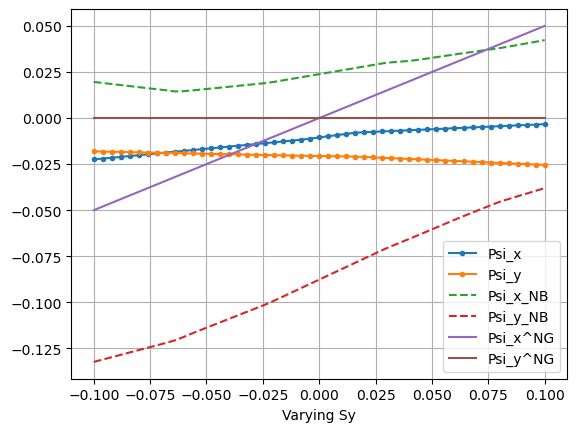

In [8]:
## Test input

U_x = 0
U_y = 0.5
V_x = 0
V_y = 0 
Sx = 0 
Sy_arr = np.linspace(-.1, .1, 51)

Psix = np.zeros_like(Sy_arr)
Psiy = np.zeros_like(Sy_arr)
Psix_nobias = np.zeros_like(Sy_arr)
Psiy_nobias = np.zeros_like(Sy_arr)
Psix_NGM = np.zeros_like(Sy_arr)
Psiy_NGM = np.zeros_like(Sy_arr)

for i,Sy in enumerate(Sy_arr):
    
    input_array = np.array([U_x, U_y, V_x, V_y, Sx, Sy])

    Psix[i], Psiy[i] = state.apply_fn(state.params, input_array)
    Psix_nobias[i], Psiy_nobias[i] = state_nobias.apply_fn(state_nobias.params, input_array)
    Psix_NGM[i], Psiy_NGM[i] = NGM_func(U_x, U_y, V_x, V_y, Sx, Sy)

plt.plot(Sy_arr, Psix, '.-', label='Psi_x')
plt.plot(Sy_arr, Psiy, '.-', label='Psi_y')

plt.plot(Sy_arr, Psix_nobias, '--', label='Psi_x_NB')
plt.plot(Sy_arr, Psiy_nobias, '--',label='Psi_y_NB')

plt.plot(Sy_arr, Psix_NGM, label='Psi_x^NG')
plt.plot(Sy_arr, Psiy_NGM, label='Psi_y^NG')

plt.legend()
plt.xlabel('Varying Sy')
plt.grid()

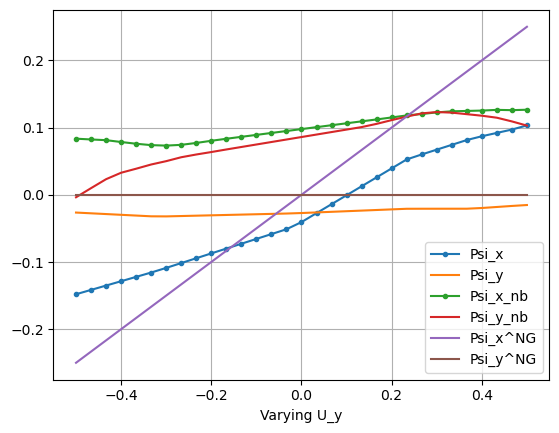

In [9]:
## Test input

U_x = 0
U_y_arr = np.linspace(-.5, 0.5, 31)
V_x = 0
V_y = 0 
Sx = 0 
Sy = 0.5
#Sy_arr = np.linspace(-.1, .1, 51)

Psix = np.zeros_like(U_y_arr)
Psiy = np.zeros_like(U_y_arr)
Psix_nobias = np.zeros_like(U_y_arr)
Psiy_nobias = np.zeros_like(U_y_arr)
Psix_NGM = np.zeros_like(U_y_arr)
Psiy_NGM = np.zeros_like(U_y_arr)


for i,U_y in enumerate(U_y_arr):
    
    input_array = np.array([U_x, U_y, V_x, V_y, Sx, Sy])

    Psix[i], Psiy[i] = state.apply_fn(state.params, input_array)
    Psix_nobias[i], Psiy_nobias[i] = state_nobias.apply_fn(state_nobias.params, input_array)
    Psix_NGM[i], Psiy_NGM[i] = NGM_func(U_x, U_y, V_x, V_y, Sx, Sy)

plt.plot(U_y_arr, Psix, '.-', label='Psi_x')
plt.plot(U_y_arr, Psiy, label='Psi_y')

plt.plot(U_y_arr, Psix_nobias, '.-', label='Psi_x_nb')
plt.plot(U_y_arr, Psiy_nobias, label='Psi_y_nb')

plt.plot(U_y_arr, Psix_NGM, label='Psi_x^NG')
plt.plot(U_y_arr, Psiy_NGM, label='Psi_y^NG')

plt.legend()
plt.xlabel('Varying U_y')
plt.grid()

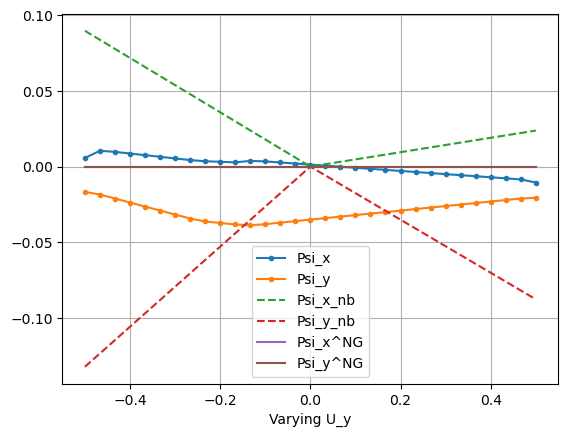

In [11]:
## Test input

U_x = 0
U_y_arr = np.linspace(-.5, 0.5, 31)
V_x = 0
V_y = 0 
Sx = 0 
Sy = 0.
#Sy_arr = np.linspace(-.1, .1, 51)

Psix = np.zeros_like(U_y_arr)
Psiy = np.zeros_like(U_y_arr)
Psix_nobias = np.zeros_like(U_y_arr)
Psiy_nobias = np.zeros_like(U_y_arr)
Psix_NGM = np.zeros_like(U_y_arr)
Psiy_NGM = np.zeros_like(U_y_arr)


for i,U_y in enumerate(U_y_arr):
    
    input_array = np.array([U_x, U_y, V_x, V_y, Sx, Sy])

    Psix[i], Psiy[i] = state.apply_fn(state.params, input_array)
    Psix_nobias[i], Psiy_nobias[i] = state_nobias.apply_fn(state_nobias.params, input_array)
    Psix_NGM[i], Psiy_NGM[i] = NGM_func(U_x, U_y, V_x, V_y, Sx, Sy)

plt.plot(U_y_arr, Psix, '.-', label='Psi_x')
plt.plot(U_y_arr, Psiy, '.-', label='Psi_y')

plt.plot(U_y_arr, Psix_nobias, '--', label='Psi_x_nb')
plt.plot(U_y_arr, Psiy_nobias, '--',label='Psi_y_nb')

plt.plot(U_y_arr, Psix_NGM, label='Psi_x^NG')
plt.plot(U_y_arr, Psiy_NGM, label='Psi_y^NG')

plt.legend()
plt.xlabel('Varying U_y')
plt.grid()

- Note that the no-bias case only goes to zero when all inputs are zero 
    - it is not zero if, even a single input is non-zero. 
    - NGM is all zero if only single inputs are non-zero.
- Another thing that is interesting is how dissimilar the bias and no bias ML models are. 
- Also the NN takes seems to take sudden turns, rather than smooth transitions. (*can this be causing problems?*)
- There is no way to setup the weights of a FCNN such that it approximates a NGM, since we can't setup explicit multiplications.
    - What this also means that like a GM or NGM model, the no-bias case may (most probably) also not end up with 0 output in regions with 0 slopes. 
    - So this gives less justification to try out no-bias. 
    - However, this does create a little more incentive to use equation discovery. 